In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Configurar Plotly para que funcione bien en el notebook
pd.options.plotting.backend = "plotly"

print("--- Loading Master Dataset ---")
try:
    df_master = pd.read_csv('../data/iris_master_dataset_v1.csv')
    print("Master dataset loaded successfully.")
    print(f"Shape: {df_master.shape}")
except FileNotFoundError:
    print("ERROR: Master dataset not found. Please run the fusion notebook first.")

--- Loading Master Dataset ---
Master dataset loaded successfully.
Shape: (2017, 8)


In [2]:
# --- The National Pulse: Distribution of Key Risk Factors ---

# Histograma del Ratio de Sobrecosto
# Filtramos valores extremos para una mejor visualización
fig1 = px.histogram(df_master[df_master['g_factor_ratio_sobrecosto_promedio'].between(-2, 5)], 
                    x="g_factor_ratio_sobrecosto_promedio",
                    title="Distribución del Ratio de Sobrecosto Promedio (G-Factor)",
                    labels={"g_factor_ratio_sobrecosto_promedio": "Ratio (Final-Inicial)/Inicial"},
                    nbins=100)
fig1.show()

# Histograma de la Edad Promedio de Fallecimiento
fig2 = px.histogram(df_master, 
                    x="s_factor_edad_prom_muerte",
                    title="Distribución de la Edad Promedio de Fallecimiento (S-Factor)",
                    labels={"s_factor_edad_prom_muerte": "Edad Promedio (años)"},
                    nbins=100)
fig2.show()

In [3]:
# --- Representación en Texto del Histograma de Sobrecosto ---

# 1. Filtramos los datos de la misma manera que en el gráfico
df_filtrado_costo = df_master[df_master['g_factor_ratio_sobrecosto_promedio'].between(-2, 5)].copy()

# 2. Creamos los "bins" o contenedores para el ratio de sobrecosto.
#    Vamos a crear 10 bins entre -2 y 5 para que la tabla sea legible.
bins_costo = pd.cut(df_filtrado_costo['g_factor_ratio_sobrecosto_promedio'], bins=10)

# 3. Contamos cuántos distritos caen en cada bin
tabla_frecuencia_costo = bins_costo.value_counts().sort_index()

print("--- Tabla de Frecuencias: Distribución del Ratio de Sobrecosto Promedio ---")
print("Rango del Ratio      | Número de Distritos")
print("-----------------------------------------")
print(tabla_frecuencia_costo)

# 4. También podemos obtener las estadísticas descriptivas clave
print("\n--- Estadísticas Descriptivas Clave (Sobrecosto) ---")
display(df_filtrado_costo['g_factor_ratio_sobrecosto_promedio'].describe())

--- Tabla de Frecuencias: Distribución del Ratio de Sobrecosto Promedio ---
Rango del Ratio      | Número de Distritos
-----------------------------------------
g_factor_ratio_sobrecosto_promedio
(-1.006, -0.442]    1959
(-0.442, 0.117]       16
(0.117, 0.675]         6
(0.675, 1.234]         6
(1.234, 1.792]         3
(1.792, 2.351]         3
(2.351, 2.909]         1
(2.909, 3.468]         2
(3.468, 4.026]         2
(4.026, 4.584]         3
Name: count, dtype: int64

--- Estadísticas Descriptivas Clave (Sobrecosto) ---


count    2001.000000
mean       -0.911833
std         0.369561
min        -1.000000
25%        -1.000000
50%        -0.983257
75%        -0.930201
max         4.584391
Name: g_factor_ratio_sobrecosto_promedio, dtype: float64

In [4]:
import pandas as pd
import plotly.graph_objects as go

# --- PASO 0: Cargar los DataFrames necesarios ---
print("Cargando los datasets 'Antes' y 'Después'...")

try:
    # Cargar el dataset crudo (ANTES)
    ruta_excel = '../data/DataSet-Obras-Publicas-23-07-2025.xlsx'
    df_raw = pd.read_excel(ruta_excel, engine='openpyxl')
    print("Dataset crudo (df_raw) cargado con éxito.")
    
    # Cargar el dataset certificado (DESPUÉS)
    # Asumo que lo guardaste como 'infobras_certificado_v1.csv'
    ruta_certificado = '../data/infobras_certificado_v_final.csv'
    df_certified = pd.read_csv(ruta_certificado, low_memory=False)
    print("Dataset certificado (df_certified) cargado con éxito.")
    
    datos_cargados = True
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo necesario. {e}")
    datos_cargados = False



Cargando los datasets 'Antes' y 'Después'...
Dataset crudo (df_raw) cargado con éxito.
Dataset certificado (df_certified) cargado con éxito.


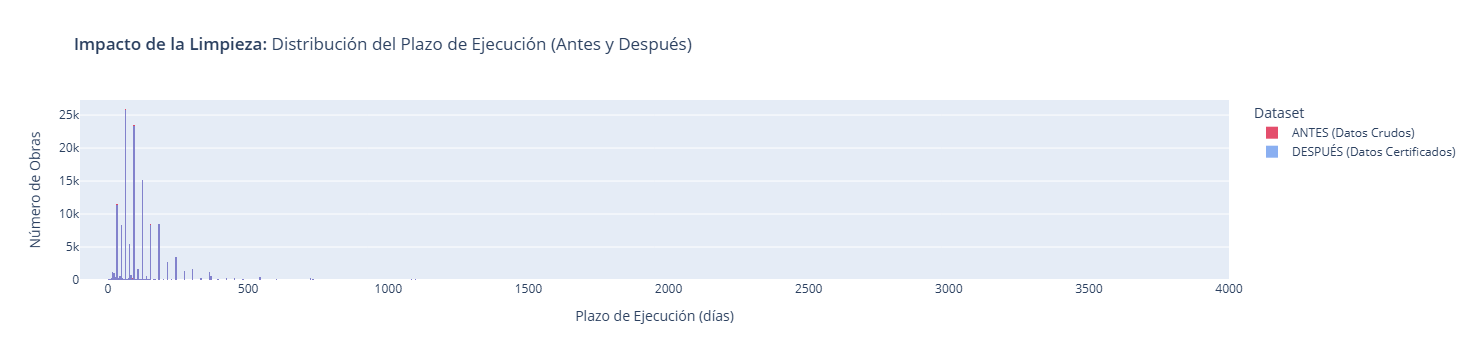

In [5]:
# --- ANTES Y DESPUÉS: Distribución del Plazo de Ejecución ---
if datos_cargados:
    # 1. Preparamos los datos "ANTES"
    plazos_antes = pd.to_numeric(df_raw['Plazo de ejecución (en dias)'], errors='coerce').dropna()

    # 2. Preparamos los datos "DESPUÉS"
    # ¡LA CORRECCIÓN ESTÁ AQUÍ!
    plazos_despues = df_certified['plazo_de_ejecucion_en_dias']

    # 3. Creamos la visualización
    fig = go.Figure()

    fig.add_trace(go.Histogram(x=plazos_antes, 
                               name='ANTES (Datos Crudos)', 
                               opacity=0.75,
                               marker_color='crimson'))

    fig.add_trace(go.Histogram(x=plazos_despues, 
                               name='DESPUÉS (Datos Certificados)', 
                               opacity=0.75,
                               marker_color='cornflowerblue'))

    fig.update_layout(
        barmode='overlay',
        title_text='<b>Impacto de la Limpieza:</b> Distribución del Plazo de Ejecución (Antes y Después)',
        xaxis_title_text='Plazo de Ejecución (días)',
        yaxis_title_text='Número de Obras',
        legend_title_text='Dataset'
    )
    
    fig.update_xaxes(range=[-100, 4000])

    fig.show()

In [6]:
# --- PASO 2: Generar el Informe Textual ---
if datos_cargados:
    print("\n\n--- ANÁLISIS TEXTUAL DEL IMPACTO DE LA LIMPIEZA DE DATOS ---")
    print("==========================================================")
    print("Variable Analizada: Plazo de Ejecución en Días\n")

    # --- Análisis del Estado INICIAL (Datos Crudos) ---
    print("--- 1. Diagnóstico del Dataset CRUDO ('Antes') ---")
    
    # Contamos los datos no plausibles
    plazos_no_positivos_raw = (plazos_antes <= 0).sum()
    plazos_extremos_raw = (plazos_antes > 3650).sum()
    
    print(f"El dataset crudo contiene {len(plazos_antes):,} registros con un plazo numérico válido.")
    print(f"  - De estos, se identificaron {plazos_no_positivos_raw:,} registros con plazos no plausibles (cero o negativos).")
    
    # Analizamos los outliers y la distribución
    media_antes = plazos_antes.mean()
    mediana_antes = plazos_antes.median()
    max_antes = plazos_antes.max()
    
    print(f"  - El valor máximo encontrado fue de {max_antes:,.0f} días (aproximadamente {max_antes/365:.1f} años), un outlier extremo.")
    print(f"  - La media ({media_antes:.1f} días) es significativamente mayor que la mediana ({mediana_antes:.1f} días), lo que confirma una distribución fuertemente sesgada a la derecha por los valores extremos.")
    print("   --> Veredicto: Los datos crudos no son fiables para el análisis debido a valores ilógicos y outliers que distorsionan las métricas.\n")

    # --- Análisis del Estado FINAL (Datos Certificados) ---
    print("--- 2. Diagnóstico del Dataset CERTIFICADO ('Después') ---")
    
    # Verificamos que los problemas se hayan corregido
    plazos_no_positivos_cert = (plazos_despues <= 0).sum()
    
    print(f"El dataset certificado contiene {len(plazos_despues):,} registros con un plazo válido y curado.")
    print(f"  - El número de registros con plazos no positivos es ahora: {plazos_no_positivos_cert}.")
    
    # Analizamos la nueva distribución
    media_despues = plazos_despues.mean()
    mediana_despues = plazos_despues.median()
    max_despues = plazos_despues.max()
    
    print(f"  - El plazo máximo ha sido curado a un valor plausible de {max_despues:,.0f} días (10 años).")
    print(f"  - La media ({media_despues:.1f}) y la mediana ({mediana_despues:.1f}) están ahora mucho más alineadas, indicando una distribución más saludable y representativa.")
    print("   --> Veredicto: Los datos certificados son coherentes, plausibles y robustos para el análisis estadístico.\n")

    # --- Resumen del Impacto ---
    print("--- 3. Resumen Cuantitativo del Impacto de la Curación ---")
    total_curados = plazos_no_positivos_raw + plazos_extremos_raw
    print(f"El proceso de curación (Pasito 8) eliminó un total de {total_curados:,} registros no plausibles, que representaban un riesgo para la integridad del análisis.")
    print("La transformación de la variable ha sido exitosa, pasando de un estado ruidoso y sesgado a uno limpio y fiable.")
    print("==========================================================")



--- ANÁLISIS TEXTUAL DEL IMPACTO DE LA LIMPIEZA DE DATOS ---
Variable Analizada: Plazo de Ejecución en Días

--- 1. Diagnóstico del Dataset CRUDO ('Antes') ---
El dataset crudo contiene 132,958 registros con un plazo numérico válido.
  - De estos, se identificaron 1 registros con plazos no plausibles (cero o negativos).
  - El valor máximo encontrado fue de 31,052 días (aproximadamente 85.1 años), un outlier extremo.
  - La media (121.1 días) es significativamente mayor que la mediana (90.0 días), lo que confirma una distribución fuertemente sesgada a la derecha por los valores extremos.
   --> Veredicto: Los datos crudos no son fiables para el análisis debido a valores ilógicos y outliers que distorsionan las métricas.

--- 2. Diagnóstico del Dataset CERTIFICADO ('Después') ---
El dataset certificado contiene 132,137 registros con un plazo válido y curado.
  - El número de registros con plazos no positivos es ahora: 0.
  - El plazo máximo ha sido curado a un valor plausible de 3,650

In [7]:
import json
import plotly.express as px

# --- The Risk Heatmap: Geographic Distribution of Risk ---

# ASUNCIÓN: Has descargado 'peru_distritos.geojson' en tu carpeta /data

try:
    with open('../data/peru_distritos.geojson') as f:
        geojson_distritos = json.load(f)
    
    # --- PREPARACIÓN DE DATOS PARA EL MAPA ---
    # El código UBIGEO en el GeoJSON suele ser texto. Asegurémonos de que el nuestro también lo sea.
    # Primero, necesitamos crear el código UBIGEO de 6 dígitos en nuestro df_master.
    # ASUNCIÓN: Tu df_infobras_certificado ya tiene 'ubigeo' como 'departamento_provincia_distrito'.
    # Necesitamos el código numérico. Si no lo tienes, este paso es más complejo.
    # POR AHORA, asumiremos que tu df_master tiene una columna 'ubigeo_codigo'.
    # Si no la tienes, necesitaremos crearla.
    
    # VAMOS A USAR UN EJEMPLO SIMPLE CON LA TASA DE PARALIZACIÓN
    df_mapa = df_master[['ubigeo', 'g_factor_tasa_paralizacion']]
    
    # --- AJUSTA ESTA LÍNEA ---
    # Reemplaza "properties.UBIGEO" con la ruta real a la clave en tu archivo GeoJSON.
    # Por ejemplo, si la clave se llama 'IDDIST', usarías "properties.IDDIST".
    feature_id_key = "properties.UBIGEO" 

    fig = px.choropleth_mapbox(df_mapa, 
                               geojson=geojson_distritos, 
                               locations='ubigeo',       # Columna en tu DataFrame con el ID
                               featureidkey=feature_id_key, # Ruta al ID en el GeoJSON
                               color='g_factor_tasa_paralizacion',
                               color_continuous_scale="Reds",
                               mapbox_style="carto-positron",
                               zoom=4, center = {"lat": -9.19, "lon": -75.015},
                               opacity=0.7,
                               title="Mapa de Calor: Tasa de Paralización de Obras por Distrito"
                              )
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

except FileNotFoundError:
    print("ERROR: Archivo 'peru_distritos.geojson' no encontrado en la carpeta /data.")
except Exception as e:
    print(f"Ha ocurrido un error al generar el mapa: {e}")

ERROR: Archivo 'peru_distritos.geojson' no encontrado en la carpeta /data.
